<a href="https://colab.research.google.com/github/on-kulyashov/Code-for-NMR-course/blob/main/HW_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

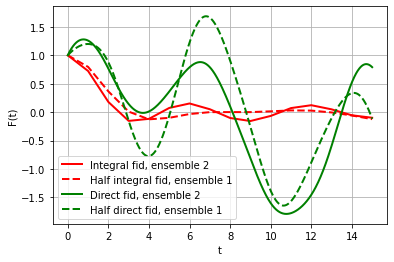

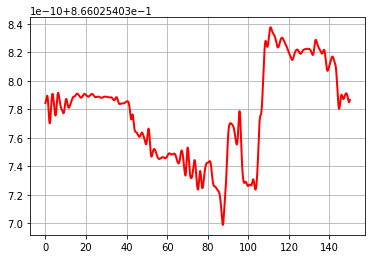

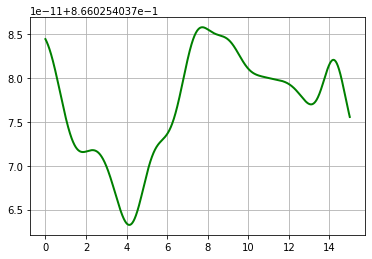

In [ ]:
import numpy as np
from scipy.linalg import schur
import matplotlib.pyplot as plt


# initial spin generation
def init_spins(num=1):
    s_0 = np.sqrt(3)/2
    spins = []
    def one_spin():
        phi_0 = np.random.uniform(0, 2*np.pi)
        s_z = np.random.uniform(-1, 1)
        return [np.sqrt(1 - s_z**2)*np.cos(phi_0), np.sqrt(1 - s_z**2)*np.sin(phi_0), s_z]
    for i in range(num):
        spins.extend(one_spin())
    return s_0 * np.array(spins)


def init_spins_polarized(num=1):
    s_0 = np.sqrt(3)/2
    spins = []
    def one_spin():
        phi_0 = np.random.uniform(0, 2*np.pi)
        p = np.random.uniform()
        s_x = (np.sqrt(40*p + 81) - 10)
        return [s_x, np.sqrt(1 - s_x**2)*np.cos(phi_0), np.sqrt(1 - s_x**2)*np.sin(phi_0)]
    for i in range(num):
        spins.extend(one_spin())
    return s_0 * np.array(spins)    


# RK4 method    
def yn1(f, yn, xn, h):
    k1 = f(xn, yn)
    k2 = f(xn + h/2, yn + h*k1/2)
    k3 = f(xn + h/2, yn + h*k2/2)
    k4 = f(xn + h, yn + h*k3)
    return yn + h/6 * (k1 + 2*k2 + 2*k3 + k4)


def integrate(f, a, b, y_a, h):
    sol = [y_a]
    for i in range(int((b-a)//h) + 1):
        sol.append(yn1(f, sol[-1], a + i*h, h))
    return sol

# evolution parameters
J_perp = -0.41
J_z = 0.82
N = 11
ensemble = 2
ensemble_direct = 2
t_1, t_2 = 0, 150
t_1_direct, t_2_direct = 0, 15
h = 0.01
t_delay_max = 15
t_decay = np.linspace(0, t_delay_max, num=t_delay_max+1)


def classical(t, s):
    s_individual = [s[i:i + 3] for i in range(0, len(s), 3)]
    evolve = []
    for i in range(N):
        pre = (i - 1 + N) % N
        aft = (i + 1 + N) % N
        h = -np.array([J_perp*(s_individual[pre][0] + s_individual[aft][0]), J_perp*(s_individual[pre][1] + s_individual[aft][1]), J_z*(s_individual[pre][2] + s_individual[aft][2])])
        evolve.extend(np.cross(s_individual[i], h))
    return np.array(evolve)


def convolution(f1, f2, t_delay):
    sum = 0
    t_delay = int(len(f2)*t_delay/(t_2 - t_1))
    integration_interval = int(len(f2)*(t_2 - t_1 - t_delay_max)/(t_2-t_1)) - 1
    for i in range(integration_interval):
        sum += f1[i]*f2[i + t_delay]
    return sum

s_evol_length = []
def free_decay(evol_operator, t_decay):
    free_ind_decay = []
    s_evol = integrate(evol_operator, t_1, t_2, init_spins(num=N), h)
    s_evol_length.append([np.sqrt(sum([s[i]**2 for i in range(3)])) for s in s_evol])
    s_evol_x_sum = [sum([s[i] for i in range(0, len(s), 3)]) for s in s_evol]
    for delay in t_decay:
        free_ind_decay.append(convolution(s_evol_x_sum, s_evol_x_sum, delay))
    return np.array(free_ind_decay)

s_evol_length_direct = []
def free_decay_direct(evol_operator, t_decay):
    free_ind_decay = []
    s_evol = integrate(evol_operator, t_1_direct, t_2_direct, init_spins_polarized(num=N), h)
    s_evol_x_sum = np.array([sum([s[i] for i in range(0, len(s), 3)]) for s in s_evol])
    s_evol_length_direct.append([np.sqrt(sum([s[i]**2 for i in range(3)])) for s in s_evol])
    free_ind_decay = s_evol_x_sum / s_evol_x_sum[0]
    return np.array(free_ind_decay)      

fid = [np.array(free_decay(classical, t_decay))]
for i in range(ensemble-1):
    fid.append(free_decay(classical, t_decay))
fid = np.array(fid)
f_sum = fid.sum(axis=0)/(fid.sum(axis=0)[0])
fid_half = fid[:(len(fid)//2)]
f_sum_half = fid_half.sum(axis=0)/(fid_half.sum(axis=0)[0])

fid_direct = [np.array(free_decay_direct(classical, t_decay))]
for i in range(ensemble_direct-1):
    fid_direct.append(free_decay_direct(classical, t_decay))
f_sum_direct = np.sum(np.array(fid_direct), axis=0)/(len(fid_direct))
fid_direct_half = fid_direct[:(len(fid_direct)//2)]
f_sum_direct_half = np.sum(np.array(fid_direct_half), axis=0)/len(fid_direct_half)

plt.plot(t_decay, f_sum, 'r-', linewidth=2.0)
plt.plot(t_decay, f_sum_half, 'r--', linewidth=2.0)
plt.plot(np.linspace(t_1_direct, t_2_direct, num=len(f_sum_direct)), f_sum_direct, 'g-', linewidth=2.0)
plt.plot(np.linspace(t_1_direct, t_2_direct, num=len(f_sum_direct_half)), f_sum_direct_half, 'g--', linewidth=2.0)
plt.xlabel("t")
plt.ylabel("F(t)")
plt.legend(["Integral fid, ensemble {}".format(ensemble),"Half integral fid, ensemble {}".format(ensemble//2), "Direct fid, ensemble {}".format(ensemble_direct), "Half direct fid, ensemble {}".format(ensemble_direct//2)])
plt.grid()
plt.show()

plt.plot(np.linspace(t_1, t_2, num=len(s_evol_length[0])), s_evol_length[0], 'r-', linewidth=2.0)
plt.grid()
plt.show()


plt.plot(np.linspace(t_1_direct, t_2_direct, num=len(s_evol_length_direct[0])), s_evol_length_direct[0], 'g-', linewidth=2.0)
plt.grid()
plt.show()